# Sustainability project - fully stochastic

Code for performing an individual-based, fully stochastic simulation of the CPR sustainability model.\
The system is a fully-connected lattice with N+K sites, where N is the total number of consumers, which we assumed is fixed, and K is the carrying capacity of resources.\
Each site, then, can host:
1. An empty slot, to be occupied by a resource $\leftrightarrow$ value 0
2. A parcel of resource $\leftrightarrow$ value 1
3. A cooperating consumer $\leftrightarrow$ value 2
4. A defecting consumer $\leftrightarrow$ value 3

In [1]:
import sys
sys.path.append('/Users/fabiomenegazzo/Documents/Università/codes')
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as scint
from scipy.interpolate import PchipInterpolator
import copy
plt.rcParams['font.size'] = 20
plt.rcParams['pcolor.shading'] = 'auto'
from IPython.display import display, Latex
from astropy.timeseries import LombScargle
from helpers import *
from Gillespie import *
from CPRsust_rates import *
from extinctionTimes import *
from CPRSust_detEqs import *
from CPRSustPlots import *

# Number of agents
N = 100
stateLabels = ['hole','resource','cooperator','defector']
# Carrying capacity of resource in terms of number of quanta of resource
K = 5*N
# Resource's birth rate
b = 1.
# Harvesting rates, not reduced!
extractionRates = np.sort(np.array([0.5,1.3]))/N
if N*extractionRates[-1]<b:
    display(Latex('Warning: $Ne_D<b$, which is an unphysical choice of parameters. The program will run anyways, just be aware!'))
# Each node represents either a consumer (cooperator or defector) or a slot of resource (full or empty)
nodeStates = [0,1,2,3]

# We will assume that all nodes are connected

# Settings for numerical simulations
# Initial conditions
x0 = 0.5
R0 = 0.5

# Length of the simulation
tMax_detRes = 100

# Number of repetitions of the simulation
NReps_detRes = 1

# Tolerance for the evaluation of the extinction times
tolerance = 1e-3

# Collect the parameters in an object to be used with the integrators
contextCommon = {
    'b' : b,
    'extractionRates' : extractionRates,
    'N' : N,
    'K' : K
}

runCase = {
    'replicator' : False,
    'kF' : False,
    'kFpP' : True
}

## Replicator dynamics

### Mean field

In [2]:
if runCase['replicator']:
    # Define the context object to be used with all integrators in the rest of the code
    context_MF = copy.copy(contextCommon)

    # Taking from the context the parameter values used by solve_ivp
    paramsString = ['b','extractionRates','N','K']
    params = evalContextVar(paramsString,context_MF)

    zSeries = scint.solve_ivp(HES,[0,tMax_detRes],[R0,x0],method='RK45',args=(params))

    # Unpack the resulting object
    seriesObj_MF = {
        'time' : zSeries.t,
        'cooperators' : zSeries.y[1],
        'resource' : zSeries.y[0]
        }

    # Time to extinction
    print('Evaluating the time to extinction')
    tExt_MF = extinctionTime_single(seriesObj_MF['time'],seriesObj_MF['resource'],tolerance)
    if not tExt_MF:
        print('\tDone. The resource remains sustainable!')
        seriesObj_MF['absorbing'] = False
    else:
        seriesObj_MF['absorbing'] = True
    print('\tDone.')

    plotsObj = [
        {
            'name' : 'Cooperators',
            'x' : seriesObj_MF['time'],
            'y': seriesObj_MF['cooperators'],
            'color' : 'royalblue',
            'xlabel' : 't',
            'ylabel' : 'x',
            'yLims' : [0, 1.1]
        },
        {
            'name' : 'Resource',
            'x' : seriesObj_MF['time'],
            'y' : seriesObj_MF['resource'],
            'color' : 'limegreen',
            'xlabel' : 't',
            'ylabel' : 'R',
            'yLims' : [0,1.1]
        }
    ]

    fig_MF, ax_MF = plt.subplots(1,2,figsize=(16,8))

    for ax,plotObj in zip(ax_MF,plotsObj):
        ax.set_title(plotObj['name'])
        ax.plot(plotObj['x'],plotObj['y'],plotObj['color'], alpha=0.4)
        ax.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
        ax.set_xlabel(plotObj['xlabel'])
        ax.set_ylabel(plotObj['ylabel'])
        ax.set_ylim(plotObj['yLims'])
        ax.grid(which='both',linestyle=':',color='k',alpha=0.25)
    if tExt_MF:
        ax_MF[1].vlines(tExt_MF,0,R0,colors='lime',linestyle='-.',label='Time to extinction')
        ax_MF[1].legend()
    plt.show()
else:
    print('Not executed. See the settings in the first cell.')

Not executed. See the settings in the first cell.


### Step back: the mixed model

For starting, we regard the dynamics on the consumers as stochastic and the resource as deterministic.

In [3]:
if runCase['replicator']:
    # Update context
    context_detRes = copy.deepcopy(context_MF)
    context_detRes['nodeStates'] = nodeStates

    # Vector of consumers (agents only, for now)
    zVec_detRes = np.ones(N,dtype=int)
    # Vector of consumers - assignment of initial conditions
    zVec_detRes[0:int(N*x0)] = setVec(zVec_detRes[0:int(N*x0)],nodeStates[2])
    zVec_detRes[int(N*x0):N] = setVec(zVec_detRes[int(N*x0):N],nodeStates[3])
else:
    print('Not executed. See the settings in the first cell.')

Not executed. See the settings in the first cell.


In [4]:
if runCase['replicator']:
    print('Launching the simulation')

    seriesObj_detRes = []

    for kRep in range(NReps_detRes):
        # Reset the vatiables of the context to their initial conditions
        context_detRes['R'] = R0
        context_detRes['K'] = K
        context_detRes['varVec'] = zVec_detRes

        print(f'\tLaunching repetition {kRep+1} of {NReps_detRes}')
        kStep = 1
        tSim_detRes_temp = [0]
        vecSim_detRes_temp = [evalContextVar(['varVec'],context_detRes)[0]]
        RSim_detRes_temp = [evalContextVar(['R'],context_detRes)[0]]

        while tSim_detRes_temp[-1] < tMax_detRes:
            # Number of iteration
            # print(kRep+1)

            # Single iteration of the Gillespie algorithm
            absState, objNew = GillespieStep(context_detRes,reactsCPRsust_homogeneous_detRes)
            if absState:
                print('\t\tThe simulation reached an absorbing state. Stopping the simulation.')
                break

            # Update time
            tProcess = objNew['t']
            tSim_detRes_temp.append(tSim_detRes_temp[-1] + tProcess)
            # print('\ttime:',tSim_detRes[-1][-1])

            # Update variables
            vecSim_detRes_temp.append(objNew['vec'])
            # print('\tnumber of cooperators',countSpecies(vecSim_detRes[-1],nodeStates[1]))

            # Update the resource deterministically
            RNew = RNew_Gillespie(context_detRes,tProcess)
            RSim_detRes_temp.append(RNew)
            context_detRes['R'] = RNew
            # print('\tResource',RNew)

            # Increase counter
            kStep+=1
        seriesObj_detRes.append({
            'time' : tSim_detRes_temp,
            'cooperators' : [speciesFrac(z,nodeStates[2]) for z in vecSim_detRes_temp],
            'resource' : RSim_detRes_temp,
            'absorbing' : absState
            })

        print(f'\t\tRepetition {kRep+1} completed\n\t\t{len(tSim_detRes_temp)} steps have been performed')

    # Reset context
    context_detRes['R'] = R0
    context_detRes['varVec'] = zVec_detRes

    print('Done')
else:
    print('Not executed. See the settings in the first cell.')

Not executed. See the settings in the first cell.


In [5]:
if runCase['replicator']:
    # Statistics of the times to extinction
    print('Evaluating the times to extinction')
    tExtObj_detRes = extinctionTimes(seriesObj_detRes)
    if not tExtObj_detRes['mean']:
        print('\tDone. The resource remains sustainable!')
    else:
        print(f'\tDone. {tExtObj_detRes['fraction']*100}% of the repetitions achieved extinction.')

    # Calculate averages
    if all(len(obj['time']) == 1 for obj in seriesObj_detRes):
        seriesObj_detRes = [seriesObj_MF.copy() for _ in range(NReps_detRes)]
        tSimAvg_detRes = seriesObj_MF['time'].copy()    
    else:
        tSimAvg_detRes = tVecCommon(seriesObj_detRes,context_detRes,reactsCPRsust_homogeneous_detRes)
    coopFracSeriesInterp_detRes = GillTimeSeriesInterp(tSimAvg_detRes,seriesObj_detRes,'cooperators')
    coopFracSeriesAvg_detRes = np.mean(coopFracSeriesInterp_detRes,axis=0)
    RSimInterp_detRes = GillTimeSeriesInterp(tSimAvg_detRes,seriesObj_detRes,'resource')
    RSimAvg_detRes = np.mean(RSimInterp_detRes,axis=0)

    plotsObj = [
            {
                'name' : 'Cooperators',
                'x' : [s['time'] for s in seriesObj_detRes],
                'xCommon' : tSimAvg_detRes,
                'y': [s['cooperators'] for s in seriesObj_detRes],
                'yMean' : coopFracSeriesAvg_detRes,
                'color' : 'royalblue',
                'xlabel' : 't',
                'ylabel' : 'x',
                'yLims' : [0, 1.1]
            },
            {
                'name' : 'Resource',
                'x' : [s['time'] for s in seriesObj_detRes],
                'xCommon' : tSimAvg_detRes,
                'y' : [s['resource'] for s in seriesObj_detRes],
                'yMean' : RSimAvg_detRes,
                'color' : 'limegreen',
                'xlabel' : 't',
                'ylabel' : 'R',
                'yLims' : [0,1.1]
            }
        ]

    fig_detRes_Avg, ax_detRes_Avg = CPRSustStocSimPlot(plotsObj)
    if tExtObj_detRes['mean']:
        ax_detRes_Avg[1].vlines(tExtObj_detRes['mean'],0,R0,colors='lime',linestyle='-.',label='Mean time to extinction')
        ax_detRes_Avg[1].legend()

    plt.show()
else:
    print('Not executed. See the settings in the first cell.')

Not executed. See the settings in the first cell.


### Fully stochastic model

Now we regard the resource as stochastic as well

In [6]:
if runCase['replicator']:
    context_stocRes = copy.deepcopy(context_detRes)
    context_stocRes['K'] = K

    tMax_stocRes = tMax_detRes

    # Full vector of individuals (agents + resource) - initialization of var
    zVec_stocRes = np.ones(N+K,dtype=int)
    # Vector of individuals - assignment of initial conditions
    zVec_stocRes[0:int(N*x0)] = setVec(zVec_stocRes[0:int(N*x0)],nodeStates[2])
    zVec_stocRes[int(N*x0):N] = setVec(zVec_stocRes[int(N*x0):N],nodeStates[3])
    zVec_stocRes[N:N+int(K*R0)] = setVec(zVec_stocRes[N:N+int(K*R0)],nodeStates[1])
    zVec_stocRes[N+int(K*R0):] = setVec(zVec_stocRes[N+int(K*R0):],nodeStates[0])
else:
    print('Not executed. See the settings in the first cell.')

Not executed. See the settings in the first cell.


In [7]:
if runCase['replicator']:
    print('Launching the simulation')

    seriesObj_stocRes = []

    for kRep in range(NReps_stocRes):
        # Reset the vatiables of the context to their initial conditions
        context_stocRes['varVec'] = zVec_stocRes

        print(f'\tLaunching repetition {kRep+1} of {NReps_stocRes}')
        kStep = 1
        tSim_stocRes_temp = [0] 
        vecSim_stocRes_temp = [evalContextVar(['varVec'],context_stocRes)[0]]

        while tSim_stocRes_temp[-1] < tMax_stocRes:
            # Number of iteration
            # print(kRep+1)

            # Single iteration of the Gillespie algorithm
            absState, objNew = GillespieStep(context_stocRes,reactsCPRsust_homogeneous_stocRes)
            if absState:
                print('\t\tThe simulation reached an absorbing state. Stopping the simulation.')
                break

            # Update time
            tProcess = objNew['t']
            tSim_stocRes_temp.append(tSim_stocRes_temp[-1] + tProcess)

            # Update variables
            vecSim_stocRes_temp.append(objNew['vec'])

            # Increase counter
            kStep+=1

        seriesObj_stocRes.append({
            'time' : tSim_stocRes_temp,
            'cooperators' : [countSpecies(z,nodeStates[2])/N for z in vecSim_stocRes_temp],
            'resource' : [countSpecies(z,nodeStates[1])/K for z in vecSim_stocRes_temp],
            'absorbing' : absState
        })
        print(f'\t\tRepetition {kRep+1} completed\n\t\t{len(tSim_stocRes_temp)} steps have been performed')

    # Reset context
    context_stocRes['varVec'] = zVec_stocRes

    print('Done')
else:
    print('Not executed. See the settings in the first cell.')

Not executed. See the settings in the first cell.


In [8]:
if runCase['replicator']:
    # Statistics of the times to extinction
    print('Evaluating the times to extinction')
    tExtObj_stocRes = extinctionTimes(seriesObj_stocRes)
    if not tExtObj_stocRes['mean']:
        print('\tDone. The resource remains sustainable!')
    else:
        print(f'\tDone. {tExtObj_stocRes['fraction']*100}% of the repetitions achieved extinction.')

    # Calculate averages
    tSimAvg_stocRes = tVecCommon(seriesObj_stocRes,context_stocRes,reactsCPRsust_homogeneous_stocRes)
    coopFracSeriesInterp_stocRes = GillTimeSeriesInterp(tSimAvg_stocRes,seriesObj_stocRes,'cooperators')
    coopFracSeriesAvg_stocRes = np.mean(coopFracSeriesInterp_stocRes,axis=0)
    RSeriesInterp_stocRes = GillTimeSeriesInterp(tSimAvg_stocRes,seriesObj_stocRes,'resource')
    RSeriesAvg_stocRes = np.mean(RSeriesInterp_stocRes,axis=0)

    plotsObj = [
        {
            'name' : 'Cooperators',
            'x' : [obj['time'] for obj in seriesObj_stocRes],
            'xCommon' : tSimAvg_stocRes,
            'y': [obj['cooperators'] for obj in seriesObj_stocRes],
            'yMean' : coopFracSeriesAvg_stocRes,
            'color' : 'royalblue',
            'xlabel' : 't',
            'ylabel' : 'x',
            'yLims' : [0, 1.1]
        },
        {
            'name' : 'Resource',
            'x' : [obj['time'] for obj in seriesObj_stocRes],
            'xCommon' : tSimAvg_stocRes,
            'y': [obj['resource'] for obj in seriesObj_stocRes],
            'yMean' : RSeriesAvg_stocRes,
            'color' : 'limegreen',
            'xlabel' : 't',
            'ylabel' : 'R',
            'yLims' : [0, 1.1]
        }
    ]

    fig_stocRes_Avg, ax_stocRes_Avg = CPRSustStocSimPlot(plotsObj)
    if tExtObj_stocRes['mean']:
        ax_stocRes_Avg[1].vlines(tExtObj_stocRes['mean'],0,R0,colors='lime',linestyle='-.',label='Mean time to extinction')
        ax_stocRes_Avg[1].legend()

    plt.show()
else:
    print('Not executed. See the settings in the first cell.')

Not executed. See the settings in the first cell.


In [9]:
if runCase['replicator']:
    plotsObj_comp = [
        {
            'name' : 'Cooperators',
            'labels' : ['Mean field','Fully stochastic (avg)'],
            'x' : [seriesObj_MF['time'], tSimAvg_stocRes],
            'y': [seriesObj_MF['cooperators'], coopFracSeriesAvg_stocRes],
            'colors' : ['royalblue','midnightblue'],
            'alphas' : [1,0.5,],
            'xlabel' : 't',
            'ylabel' : 'x',
            'yLims' : [0, 1.1]
        },
        {
            'name' : 'Resource',
            'labels' : ['Mean field','Fully stochastic (avg)'],
            'x' : [seriesObj_MF['time'], tSimAvg_stocRes],
            'xExt' : [tExt_MF, tExtObj_stocRes['mean']],
            'y' : [seriesObj_MF['resource'], RSeriesAvg_stocRes],
            'colors' : ['lime','darkgreen'],
            'alphas' : [1,0.5],
            'xlabel' : 't',
            'ylabel' : 'R',
            'yLims' : [0, 1.1]
        }
    ]

    fig_comp, ax_comp = plt.subplots(1,2,figsize=(16,8))

    for ax,plotObj in zip(ax_comp,plotsObj_comp):
        ax.set_title(plotObj['name'])
        for t,y,col,a,l in zip (plotObj['x'],plotObj['y'],plotObj['colors'],plotObj['alphas'],plotObj['labels']):
            ax.plot(t,y,color=col,alpha=a,label=l)
        ax.legend()
        ax.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
        ax.set_xlabel(plotObj['xlabel'])
        ax.set_ylabel(plotObj['ylabel'])
        ax.set_ylim(plotObj['yLims'])
        ax.grid(which='both',linestyle=':',color='k',alpha=0.25)
    for tExt,col in zip(plotsObj_comp[1]['xExt'],plotsObj_comp[1]['colors']):
        if tExt:
            ax_comp[1].vlines(tExt,0,R0,colors=col,linestyle='-.')

    plt.show()
else:
    print('Not executed. See the settings in the first cell.')

Not executed. See the settings in the first cell.


# Knowledge feedback

Consumers select their strategy on the basis of the global level of resource.


## Mean field

In [10]:
if runCase['kF']:
    context_kF_MF = copy.copy(contextCommon)

    # Taking from the context the parameter values used by solve_ivp
    paramsString_kF = ['b','extractionRates','N','K']
    params = evalContextVar(paramsString_kF,context_kF_MF)

    zSeries = scint.solve_ivp(HES_knowledgeFeedback,[0,tMax_detRes],[R0,x0],method='RK45',args=(params))

    # Unpack the resulting object
    seriesObj_kF_MF = {
        'time' : zSeries.t,
        'cooperators' : zSeries.y[1],
        'resource' : zSeries.y[0]
        }

    # Time to extinction
    print('Evaluating the time to extinction')
    tExt_kF_MF = extinctionTime_single(seriesObj_kF_MF['time'],seriesObj_kF_MF['resource'],tolerance)
    if not tExt_kF_MF:
        print('\tDone. The resource remains sustainable!')
        seriesObj_kF_MF['absorbing'] = False
    else:
        seriesObj_kF_MF['absorbing'] = True
    print('\tDone.')

    plotsObj = [
        {
            'name' : 'Cooperators',
            'x' : seriesObj_kF_MF['time'],
            'y': seriesObj_kF_MF['cooperators'],
            'color' : 'royalblue',
            'xlabel' : 't',
            'ylabel' : 'x',
            'yLims' : [0, 1.1]
        },
        {
            'name' : 'Resource',
            'x' : seriesObj_kF_MF['time'],
            'y' : seriesObj_kF_MF['resource'],
            'color' : 'limegreen',
            'xlabel' : 't',
            'ylabel' : 'R',
            'yLims' : [0,1.1]
        }
    ]

    fig_kF_MF, ax_kF_MF = plt.subplots(1,2,figsize=(16,8))

    for ax,plotObj in zip(ax_kF_MF,plotsObj):
        ax.set_title(plotObj['name'])
        ax.plot(plotObj['x'],plotObj['y'],plotObj['color'], alpha=0.4)
        ax.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
        ax.set_xlabel(plotObj['xlabel'])
        ax.set_ylabel(plotObj['ylabel'])
        ax.set_ylim(plotObj['yLims'])
        ax.grid(which='both',linestyle=':',color='k',alpha=0.25)
    if tExt_kF_MF:
        ax_kF_MF[1].vlines(tExt_MF,0,R0,colors='lime',linestyle='-.',label='Time to extinction')
        ax_kF_MF[1].legend()
    plt.show()
else:
    print('Not executed. See the settings in the first cell.')

Not executed. See the settings in the first cell.


## Fully stochastic model

In [11]:
if runCase['kF']:
    context_stocRes = {
        'b' : b,
        'extractionRates' : extractionRates,
        'N' : N,
        'K' : K,
        'nodeStates' : nodeStates
    }

    tMax_stocRes = 100

    NReps_kF_stocRes = 10

    # Full vector of individuals (agents + resource) - redefine the var
    zVec_stocRes = np.ones(N+K,dtype=int)
    # Vector of individuals - assignment of initial conditions
    zVec_stocRes[0:int(N*x0)] = setVec(zVec_stocRes[0:int(N*x0)],nodeStates[2])
    zVec_stocRes[int(N*x0):N] = setVec(zVec_stocRes[int(N*x0):N],nodeStates[3])
    zVec_stocRes[N:N+int(K*R0)] = setVec(zVec_stocRes[N:N+int(K*R0)],nodeStates[1])
    zVec_stocRes[N+int(K*R0):] = setVec(zVec_stocRes[N+int(K*R0):],nodeStates[0])
else:
    print('Not executed. See the settings in the first cell.')

Not executed. See the settings in the first cell.


In [12]:
if runCase['kF']:
    print('Launching the simulation')

    seriesObj_kF_stocRes = []

    for kRep in range(NReps_kF_stocRes):
        # Reset the vatiables of the context to their initial conditions
        context_stocRes['R'] = R0
        context_stocRes['varVec'] = zVec_stocRes

        print(f'\tLaunching repetition {kRep+1} of {NReps_kF_stocRes}')
        kStep = 1
        tSim_stocRes_temp = [0] 
        vecSim_stocRes_temp = [evalContextVar(['varVec'],context_stocRes)[0]]

        while tSim_stocRes_temp[-1] < tMax_stocRes:
            # Number of iteration
            # print(kRep+1)

            # Single iteration of the Gillespie algorithm
            absState, objNew = GillespieStep(context_stocRes,reactsCPRsust_homogeneous_knowledgeFeedback_stocRes)
            if absState:
                print('\t\tThe simulation reached an absorbing state. Stopping the simulation.')
                break

            # Update time
            tProcess = objNew['t']
            tSim_stocRes_temp.append(tSim_stocRes_temp[-1] + tProcess)

            # Update variables
            vecSim_stocRes_temp.append(objNew['vec'])

            # Increase counter
            kStep+=1

        seriesObj_kF_stocRes.append({
            'time' : tSim_stocRes_temp,
            'cooperators' : [countSpecies(z,nodeStates[2])/N for z in vecSim_stocRes_temp],
            'resource' : [countSpecies(z,nodeStates[1])/K for z in vecSim_stocRes_temp],
            'absorbing' : absState
        })
        print(f'\t\tRepetition {kRep+1} completed\n\t\t{len(tSim_stocRes_temp)} steps have been performed')

    # Reset context
    context_stocRes['varVec'] = zVec_stocRes

    print('Done')
else:
    print('Not executed. See the settings in the first cell.')

Not executed. See the settings in the first cell.


In [13]:
if runCase['kF']:
    # Statistics of the times to extinction
    print('Evaluating the times to extinction')
    tExtObj_kF_stocRes = extinctionTimes(seriesObj_kF_stocRes)
    if not tExtObj_kF_stocRes['mean']:
        print('\tDone. The resource remains sustainable!')
    else:
        print(f'\tDone. {tExtObj_kF_stocRes['fraction']*100}% of the repetitions achieved extinction.')

    # Calculate averages
    tSimAvg_kF_stocRes = tVecCommon(seriesObj_kF_stocRes,context_stocRes,reactsCPRsust_homogeneous_knowledgeFeedback_stocRes)
    coopFracSeriesInterp_stocRes = GillTimeSeriesInterp(tSimAvg_kF_stocRes,seriesObj_kF_stocRes,'cooperators')
    coopFracSeriesAvg_kF_stocRes = np.mean(coopFracSeriesInterp_stocRes,axis=0)
    RSeriesInterp_stocRes = GillTimeSeriesInterp(tSimAvg_kF_stocRes,seriesObj_kF_stocRes,'resource')
    RSeriesAvg_kF_stocRes = np.mean(RSeriesInterp_stocRes,axis=0)

    plotsObj = [
        {
            'name' : 'Cooperators',
            'x' : [obj['time'] for obj in seriesObj_kF_stocRes],
            'xCommon' : tSimAvg_kF_stocRes,
            'y': [obj['cooperators'] for obj in seriesObj_kF_stocRes],
            'yMean' : coopFracSeriesAvg_kF_stocRes,
            'color' : 'royalblue',
            'xlabel' : 't',
            'ylabel' : 'x',
            'xLims' : [],
            'yLims' : [0, 1.1]
        },
        {
            'name' : 'Resource',
            'x' : [obj['time'] for obj in seriesObj_kF_stocRes],
            'xCommon' : tSimAvg_kF_stocRes,
            'y': [obj['resource'] for obj in seriesObj_kF_stocRes],
            'yMean' : RSeriesAvg_kF_stocRes,
            'color' : 'limegreen',
            'xlabel' : 't',
            'ylabel' : 'R',
            'xLims' : [],
            'yLims' : [0, 1.1]
        }
    ]

    fig_kF_stocRes_Avg, ax_kF_stocRes_Avg = CPRSustStocSimPlot(plotsObj)
    if tExtObj_kF_stocRes['mean']:
        ax_kF_stocRes_Avg[1].vlines(tExtObj_kF_stocRes['mean'],0,R0,colors='lime',linestyle='-.',label='Mean time to extinction')
        ax_kF_stocRes_Avg[1].legend()

    plt.show()
else:
    print('Not executed. See the settings in the first cell.')

Not executed. See the settings in the first cell.


In [14]:
if runCase['kF']:
    plotsObj_comp = [
        {
            'name' : 'Cooperators',
            'labels' : ['Mean field','Fully stochastic (avg)'],
            'x' : [seriesObj_kF_MF['time'], tSimAvg_kF_stocRes],
            'y': [seriesObj_kF_MF['cooperators'], coopFracSeriesAvg_kF_stocRes],
            'colors' : ['royalblue','midnightblue'],
            'alphas' : [1,0.5,],
            'xlabel' : 't',
            'ylabel' : 'x',
            'yLims' : [0, 1.1]
        },
        {
            'name' : 'Resource',
            'labels' : ['Mean field','Fully stochastic (avg)'],
            'x' : [seriesObj_kF_MF['time'], tSimAvg_kF_stocRes],
            'xExt' : [tExt_kF_MF, tExtObj_kF_stocRes['mean']],
            'y' : [seriesObj_kF_MF['resource'], RSeriesAvg_kF_stocRes],
            'colors' : ['lime','darkgreen'],
            'alphas' : [1,0.5],
            'xlabel' : 't',
            'ylabel' : 'R',
            'yLims' : [0, 1.1]
        }
    ]

    fig_kF_comp, ax_kF_comp = plt.subplots(1,2,figsize=(16,8))

    for ax,plotObj in zip(ax_kF_comp,plotsObj_comp):
        ax.set_title(plotObj['name'])
        for t,y,col,a,l in zip (plotObj['x'],plotObj['y'],plotObj['colors'],plotObj['alphas'],plotObj['labels']):
            ax.plot(t,y,color=col,alpha=a,label=l)
        ax.legend()
        ax.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
        ax.set_xlabel(plotObj['xlabel'])
        ax.set_ylabel(plotObj['ylabel'])
        ax.set_ylim(plotObj['yLims'])
        ax.grid(which='both',linestyle=':',color='k',alpha=0.25)
    for tExt,col in zip(plotsObj_comp[1]['xExt'],plotsObj_comp[1]['colors']):
        if tExt:
            ax_kF_comp[1].vlines(tExt,0,R0,colors=col,linestyle='-.')

    plt.show()
else:
    print('Not executed. See the settings in the first cell.')

Not executed. See the settings in the first cell.


### Power spectrum

In [15]:
if runCase['kF']:
    # Time threshold for identifying the transient and calculate the power spectrum
    tThPS = 20
    # Range of frequencies over which to calculate the power spectrum
    omegaRange = [1/(tMax_stocRes-tThPS), 2*np.pi]
    #Select the absorbing simulations
    seriesObj_kF_PS = [obj for obj in seriesObj_kF_stocRes if obj['absorbing']==False]

    freqCoopsKF = []
    psCoopsKF = []
    freqResKF = []
    psResKF = []

    for obj in seriesObj_kF_PS:
        tVecTemp = np.array(obj['time'])
        idxPSTemp = np.where(tVecTemp>tThPS)[0]
        tVecTemp = tVecTemp[idxPSTemp]
        xVecTemp = np.array(obj['cooperators'])[idxPSTemp]
        RVecTemp = np.array(obj['resource'])[idxPSTemp]
        freqCoopsKFTemp, psCoopsKFTemp = LombScargle(t=tVecTemp,y=xVecTemp,dy=None,fit_mean=False,center_data=True,nterms=1,normalization='psd').autopower(method='fast',minimum_frequency=omegaRange[0],maximum_frequency=omegaRange[-1])
        freqCoopsKF.append(freqCoopsKFTemp)
        psCoopsKF.append(psCoopsKFTemp)
        freqResKFTemp, psResKFTemp = LombScargle(t=tVecTemp,y=RVecTemp,dy=None,fit_mean=False,center_data=True,nterms=1,normalization='psd').autopower(method='fast',minimum_frequency=omegaRange[0],maximum_frequency=omegaRange[-1])
        freqResKF.append(freqResKFTemp)
        psResKF.append(psResKFTemp)

    # Average
    freqKFCommon = np.linspace(omegaRange[0],omegaRange[1],100000)

    psCoopsKFInterp = []
    for f,ps in zip(freqCoopsKF,psCoopsKF):
        psInterpObj = PchipInterpolator(f,ps,extrapolate=False)
        psInterp = psInterpObj(freqKFCommon)
        psCoopsKFInterp.append(psInterp)
    psCoopsKFAvg = np.mean(psCoopsKFInterp, axis=0)

    psResKFInterp = []
    for f,ps in zip(freqResKF,psResKF):
        psInterpObj = PchipInterpolator(f,ps,extrapolate=False)
        psInterp = psInterpObj(freqKFCommon)
        psResKFInterp.append(psInterp)
    psResKFAvg = np.mean(psResKFInterp, axis=0)

In [16]:
if runCase['kF']: 
    plotsObjPS = [
        {
            'name' : 'cooperators',
            'x' : [np.array(f) for f in freqCoopsKF],
            'xCommon' : freqKFCommon,
            'y' : psCoopsKF,
            'yMean' : psCoopsKFAvg,
            'color' : 'royalblue',
            'xlabel' : 'f',
            'ylabel' : 'x',
            'xLims' : [-0.05,0.25],
            'yLims' : []
        },
        {
            'name' : 'resource',
            'x' : [np.array(f) for f in freqResKF],
            'xCommon' : freqKFCommon,
            'y' : psResKF,
            'yMean' : psResKFAvg,
            'color' : 'limegreen',
            'xlabel' : 'f',
            'ylabel' : 'R',
            'xLims' : [-0.05,0.25],
            'yLims' : []
        }
    ]

    figKFPS, axKFPS = CPRSustStocSimPlot(plotsObjPS)

## Knowledge feedback and peer pressure

Difference with the previous case:

$\qquad T_{kFpP}(c+1,d-1,r) = x \, T_{kF}(c+1,d-1,r) = x \, p^+ \, d$

$\qquad T_{kFpP}(c-1,d+1,r) = x \, T_{kF}(c-1,d+1,r) = (1-x) \, p^- \, c$

### Mean field

Evaluating the time to extinction
	Done. The resource remains sustainable!
	Done.


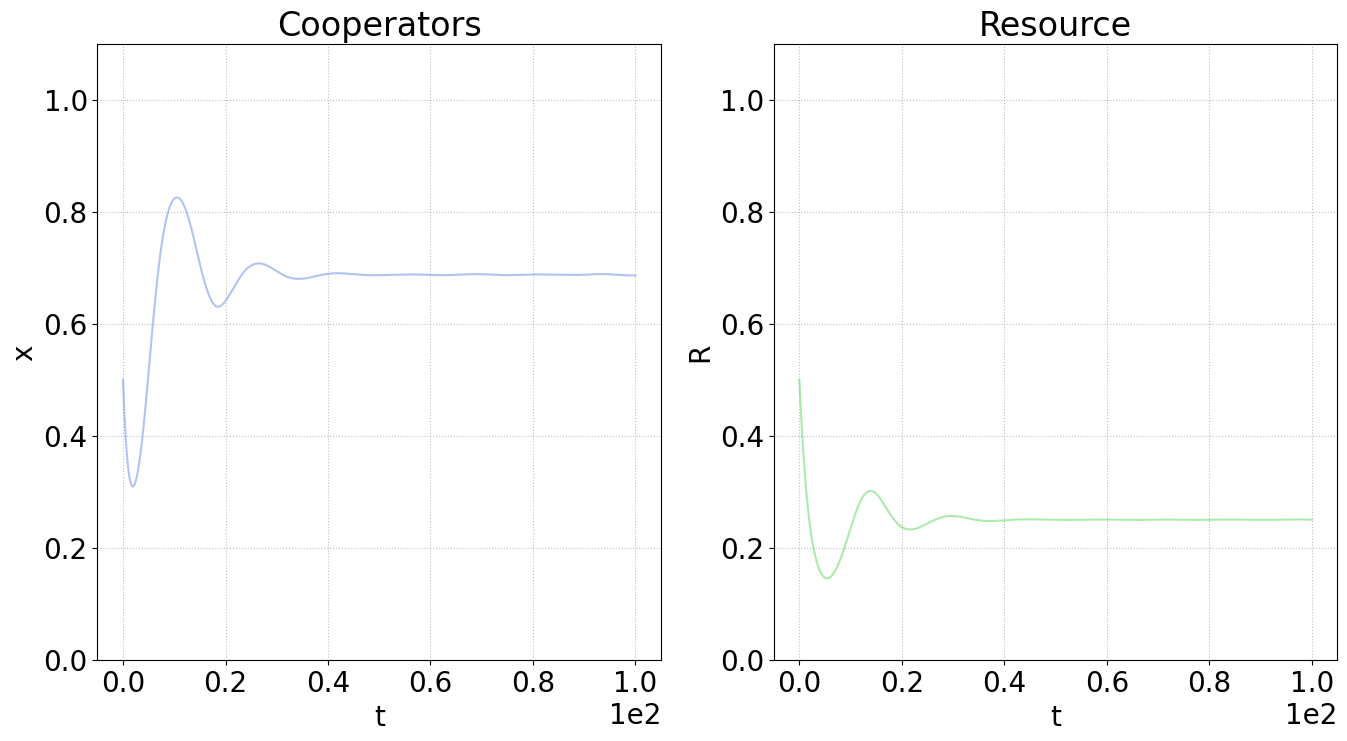

In [17]:
if runCase['kFpP']:
    context_kFpP_MF = copy.copy(contextCommon)

    # Taking from the context the parameter values used by solve_ivp
    paramsString_kFpP = ['b','extractionRates','N','K']
    params = evalContextVar(paramsString_kFpP,context_kFpP_MF)

    tEvalDet = np.linspace(0,tMax_detRes,1000)

    zSeries = scint.solve_ivp(HES_kFpP,[0,tMax_detRes],[R0,x0],method='RK45',t_eval=tEvalDet,args=(params))

    # Unpack the resulting object
    seriesObj_kFpP_MF = {
        'time' : zSeries.t,
        'cooperators' : zSeries.y[1],
        'resource' : zSeries.y[0]
        }

    # Time to extinction
    print('Evaluating the time to extinction')
    tExt_kFpP_MF = extinctionTime_single(seriesObj_kFpP_MF['time'],seriesObj_kFpP_MF['resource'],tolerance)
    if not tExt_kFpP_MF:
        print('\tDone. The resource remains sustainable!')
        seriesObj_kFpP_MF['absorbing'] = False
    else:
        seriesObj_kFpP_MF['absorbing'] = True
    print('\tDone.')

    plotsObj = [
        {
            'name' : 'Cooperators',
            'x' : seriesObj_kFpP_MF['time'],
            'y': seriesObj_kFpP_MF['cooperators'],
            'color' : 'royalblue',
            'xlabel' : 't',
            'ylabel' : 'x',
            'yLims' : [0, 1.1]
        },
        {
            'name' : 'Resource',
            'x' : seriesObj_kFpP_MF['time'],
            'y' : seriesObj_kFpP_MF['resource'],
            'color' : 'limegreen',
            'xlabel' : 't',
            'ylabel' : 'R',
            'yLims' : [0,1.1]
        }
    ]

    fig_kFpP_MF, ax_kFpP_MF = plt.subplots(1,2,figsize=(16,8))

    for ax,plotObj in zip(ax_kFpP_MF,plotsObj):
        ax.set_title(plotObj['name'])
        ax.plot(plotObj['x'],plotObj['y'],plotObj['color'], alpha=0.4)
        ax.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
        ax.set_xlabel(plotObj['xlabel'])
        ax.set_ylabel(plotObj['ylabel'])
        ax.set_ylim(plotObj['yLims'])
        ax.grid(which='both',linestyle=':',color='k',alpha=0.25)
    if tExt_kFpP_MF:
        ax_kF_MF[1].vlines(tExt_MF,0,R0,colors='lime',linestyle='-.',label='Time to extinction')
        ax_kF_MF[1].legend()
    plt.show()
else:
    print('Not executed. See the settings in the first cell.')

### Stochastic

In [18]:
if runCase['kFpP']:
    context_stocRes = {
        'b' : b,
        'extractionRates' : extractionRates,
        'N' : N,
        'K' : K,
        'nodeStates' : nodeStates
    }

    tMax_stocRes = 100

    NReps_kFpP_stocRes = 3
    # Full vector of individuals (agents + resource) - redefine the var
    zVec_stocRes = np.ones(N+K,dtype=int)
    # Vector of individuals - assignment of initial conditions
    zVec_stocRes[0:int(N*x0)] = setVec(zVec_stocRes[0:int(N*x0)],nodeStates[2])
    zVec_stocRes[int(N*x0):N] = setVec(zVec_stocRes[int(N*x0):N],nodeStates[3])
    zVec_stocRes[N:N+int(K*R0)] = setVec(zVec_stocRes[N:N+int(K*R0)],nodeStates[1])
    zVec_stocRes[N+int(K*R0):] = setVec(zVec_stocRes[N+int(K*R0):],nodeStates[0])
    
    print('Launching the simulation')

    seriesObj_kFpP_stocRes = []

    for kRep in range(NReps_kFpP_stocRes):
        # Reset the vatiables of the context to their initial conditions
        context_stocRes['R'] = R0
        context_stocRes['varVec'] = zVec_stocRes

        print(f'\tLaunching repetition {kRep+1} of {NReps_kFpP_stocRes}')
        kStep = 1
        tSim_stocRes_temp = [0] 
        vecSim_stocRes_temp = [evalContextVar(['varVec'],context_stocRes)[0]]

        while tSim_stocRes_temp[-1] < tMax_stocRes:
            # Number of iteration
            # print(kRep+1)

            # Single iteration of the Gillespie algorithm
            absState, objNew = GillespieStep(context_stocRes,reactsCPRsust_homogeneous_kFpP_stocRes)
            if absState:
                print('\t\tThe simulation reached an absorbing state. Stopping the simulation.')
                break

            # Update time
            tProcess = objNew['t']
            tSim_stocRes_temp.append(tSim_stocRes_temp[-1] + tProcess)

            # Update variables
            vecSim_stocRes_temp.append(objNew['vec'])

            # Increase counter
            kStep+=1

        seriesObj_kFpP_stocRes.append({
            'time' : tSim_stocRes_temp,
            'cooperators' : [countSpecies(z,nodeStates[2])/N for z in vecSim_stocRes_temp],
            'resource' : [countSpecies(z,nodeStates[1])/K for z in vecSim_stocRes_temp],
            'absorbing' : absState
        })
        print(f'\t\tRepetition {kRep+1} completed\n\t\t{len(tSim_stocRes_temp)} steps have been performed')

    # Reset context
    context_stocRes['varVec'] = zVec_stocRes

    print('Done')
else:
    print('Not executed. See the settings in the first cell.')

Launching the simulation
	Launching repetition 1 of 3
		Repetition 1 completed
		20855 steps have been performed
	Launching repetition 2 of 3
		Repetition 2 completed
		20088 steps have been performed
	Launching repetition 3 of 3
		Repetition 3 completed
		20454 steps have been performed
Done


In [21]:
if runCase['kFpP']:
    # Statistics of the times to extinction
    print('Evaluating the times to extinction')
    tExtObj_kFpP_stocRes = extinctionTimes(seriesObj_kFpP_stocRes)
    if not tExtObj_kFpP_stocRes['mean']:
        print('\tDone. The resource remains sustainable!')
    else:
        print(f'\tDone. {tExtObj_kFpP_stocRes['fraction']*100}% of the repetitions achieved extinction.')

    # Calculate averages
    tSimAvg_kFpP_stocRes = tVecCommon(seriesObj_kFpP_stocRes,context_stocRes,reactsCPRsust_homogeneous_kFpP_stocRes)
    coopFracSeriesInterp_stocRes = GillTimeSeriesInterp(tSimAvg_kFpP_stocRes,seriesObj_kFpP_stocRes,'cooperators')
    coopFracSeriesAvg_kFpP_stocRes = np.mean(coopFracSeriesInterp_stocRes,axis=0)
    RSeriesInterp_stocRes = GillTimeSeriesInterp(tSimAvg_kFpP_stocRes,seriesObj_kFpP_stocRes,'resource')
    RSeriesAvg_kFpP_stocRes = np.mean(RSeriesInterp_stocRes,axis=0)
else:
    print('Not executed. See the settings in the first cell.')

Evaluating the times to extinction
	Done. The resource remains sustainable!


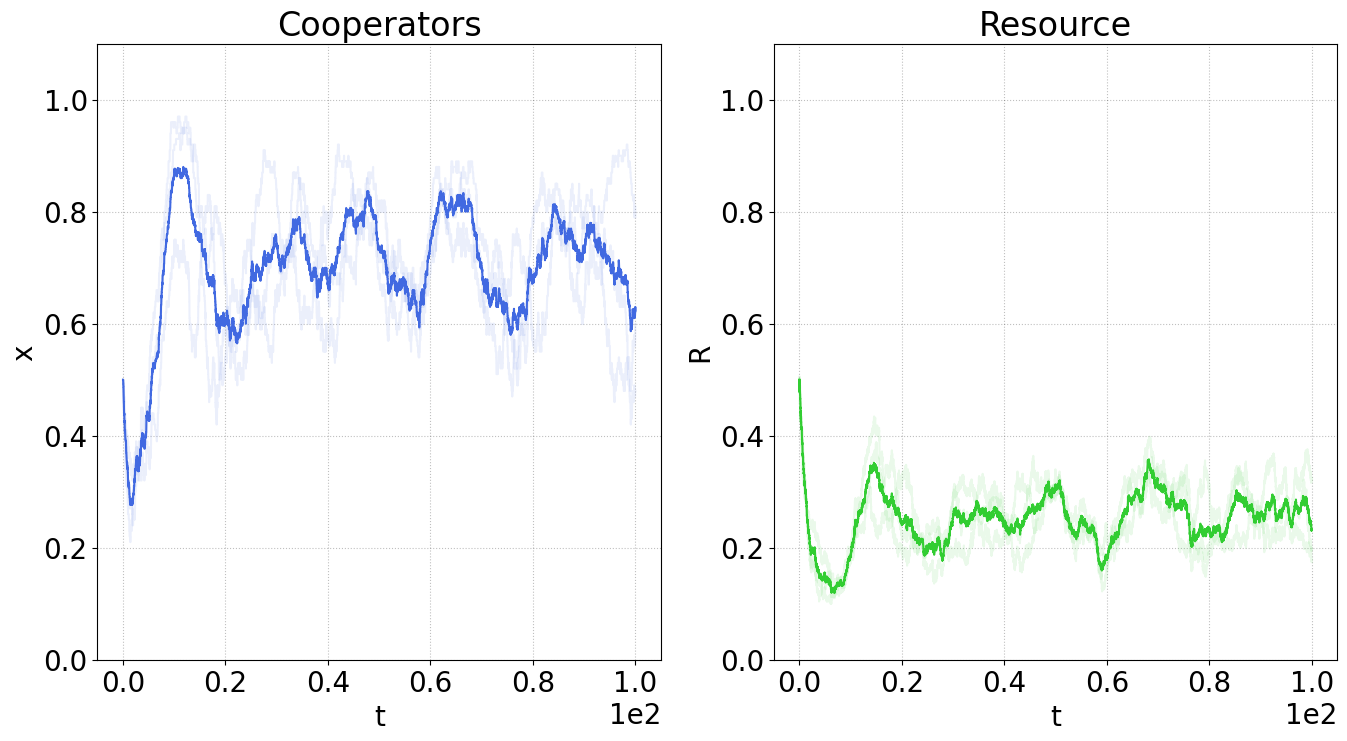

In [25]:
if runCase['kFpP']:
    plotsObj = [
        {
            'name' : 'Cooperators',
            'x' : [obj['time'] for obj in seriesObj_kFpP_stocRes],
            'xCommon' : tSimAvg_kFpP_stocRes,
            'y': [obj['cooperators'] for obj in seriesObj_kFpP_stocRes],
            'yMean' : coopFracSeriesAvg_kFpP_stocRes,
            'color' : 'royalblue',
            'xlabel' : 't',
            'ylabel' : 'x',
            'xLims' : [],
            'yLims' : [0, 1.1],
            'xLogScale' : None,
            'yLogScale' : None,
            'alphaSingle' : 0.1
        },
        {
            'name' : 'Resource',
            'x' : [obj['time'] for obj in seriesObj_kFpP_stocRes],
            'xCommon' : tSimAvg_kFpP_stocRes,
            'y': [obj['resource'] for obj in seriesObj_kFpP_stocRes],
            'yMean' : RSeriesAvg_kFpP_stocRes,
            'color' : 'limegreen',
            'xlabel' : 't',
            'ylabel' : 'R',
            'xLims' : [],
            'yLims' : [0, 1.1],
            'xLogScale' : None,
            'yLogScale' : None,
            'alphaSingle' : 0.1
        }
    ]

    fig_kFpP_stocRes_Avg, ax_kFpP_stocRes_Avg = CPRSustStocSimPlot(plotsObj)
    if tExtObj_kFpP_stocRes['mean']:
        ax_kFpP_stocRes_Avg[1].vlines(tExtObj_kFpP_stocRes['mean'],0,R0,colors='lime',linestyle='-.',label='Mean time to extinction')
        ax_kFpP_stocRes_Avg[1].legend()

    plt.show()
else:
    print('Not executed. See the settings in the first cell.')

### Power spectrum

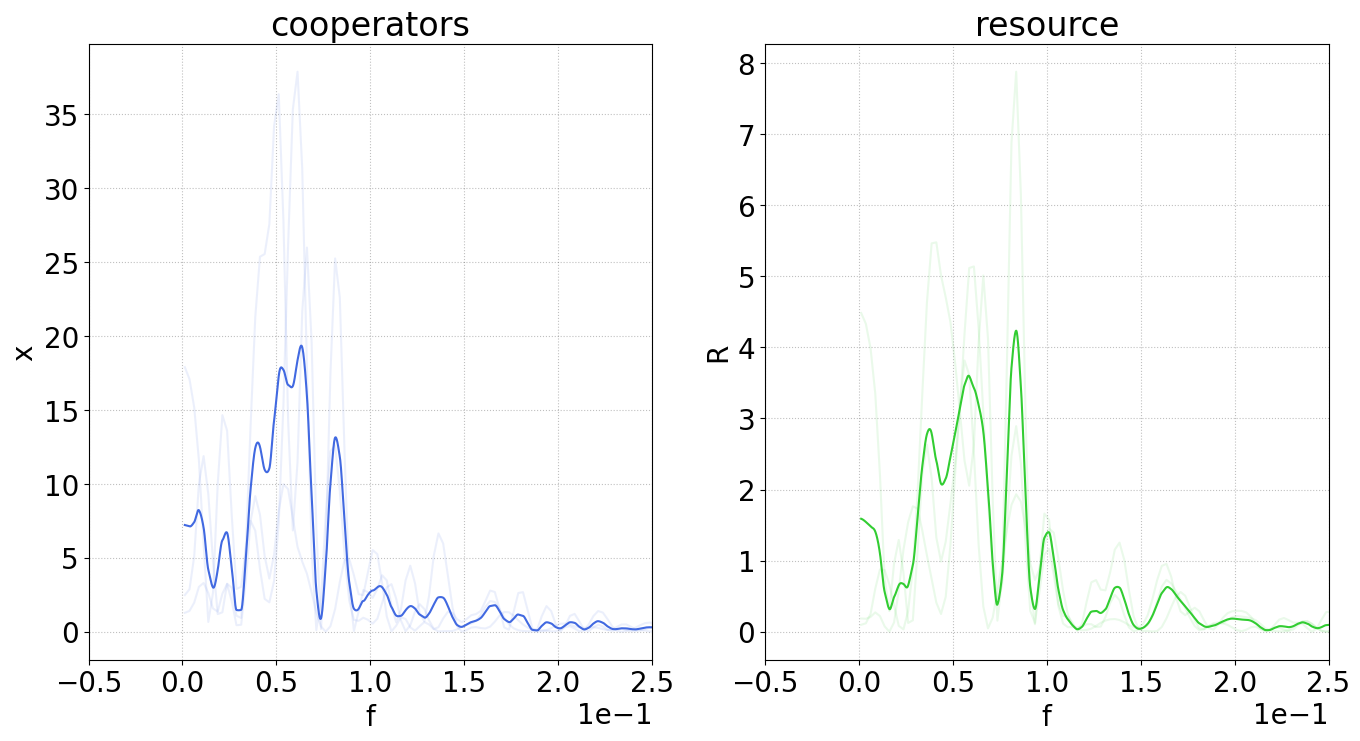

In [31]:
if runCase['kFpP']:
    # Time threshold for identifying the transient and calculate the power spectrum
    tThPS = 20
    # Range of frequencies over which to calculate the power spectrum
    omegaRange = [0.1*1/(tMax_stocRes-tThPS), 2*np.pi]
    #Select the absorbing simulations
    seriesObj_kFpP_PS = [obj for obj in seriesObj_kFpP_stocRes if obj['absorbing']==False]

    freqCoopsKFpP = []
    psCoopsKFpP = []
    freqResKFpP = []
    psResKFpP = []

    for obj in seriesObj_kFpP_PS:
        tVecTemp = np.array(obj['time'])
        idxPSTemp = np.where(tVecTemp>tThPS)[0]
        tVecTemp = tVecTemp[idxPSTemp]
        xVecTemp = np.array(obj['cooperators'])[idxPSTemp]
        RVecTemp = np.array(obj['resource'])[idxPSTemp]
        freqCoopsKFpPTemp, psCoopsKFpPTemp = LombScargle(t=tVecTemp,y=xVecTemp,dy=None,fit_mean=False,center_data=True,nterms=1,normalization='psd').autopower(method='fast',minimum_frequency=omegaRange[0],maximum_frequency=omegaRange[-1])
        freqCoopsKFpP.append(freqCoopsKFpPTemp)
        psCoopsKFpP.append(psCoopsKFpPTemp)
        freqResKFpPTemp, psResKFpPTemp = LombScargle(t=tVecTemp,y=RVecTemp,dy=None,fit_mean=False,center_data=True,nterms=1,normalization='psd').autopower(method='fast',minimum_frequency=omegaRange[0],maximum_frequency=omegaRange[-1])
        freqResKFpP.append(freqResKFpPTemp)
        psResKFpP.append(psResKFpPTemp)

    # Average
    freqKFpPCommon = np.linspace(omegaRange[0],omegaRange[1],100000)

    psCoopsKFpPInterp = []
    for f,ps in zip(freqCoopsKFpP,psCoopsKFpP):
        psInterpObj = PchipInterpolator(f,ps,extrapolate=False)
        psInterp = psInterpObj(freqKFpPCommon)
        psCoopsKFpPInterp.append(psInterp)
    psCoopsKFpPAvg = np.mean(psCoopsKFpPInterp, axis=0)

    psResKFpPInterp = []
    for f,ps in zip(freqResKFpP,psResKFpP):
        psInterpObj = PchipInterpolator(f,ps,extrapolate=False)
        psInterp = psInterpObj(freqKFpPCommon)
        psResKFpPInterp.append(psInterp)
    psResKFpPAvg = np.mean(psResKFpPInterp, axis=0)

    plotsObjPS = [
        {
            'name' : 'cooperators',
            'x' : [np.array(f) for f in freqCoopsKFpP],
            'xCommon' : freqKFpPCommon,
            'y' : psCoopsKFpP,
            'yMean' : psCoopsKFpPAvg,
            'color' : 'royalblue',
            'xlabel' : 'f',
            'ylabel' : 'x',
            'xLims' : [-0.05,0.25],
            'yLims' : [],
            'xLogScale' : None,
            'yLogScale' : None,
            'alphaSingle' : 0.1
        },
        {
            'name' : 'resource',
            'x' : [np.array(f) for f in freqResKFpP],
            'xCommon' : freqKFpPCommon,
            'y' : psResKFpP,
            'yMean' : psResKFpPAvg,
            'color' : 'limegreen',
            'xlabel' : 'f',
            'ylabel' : 'R',
            'xLims' : [-0.05,0.25],
            'yLims' : [],
            'xLogScale' : None,
            'yLogScale' : None,
            'alphaSingle' : 0.1
        }
    ]

    figKFPS, axKFPS = CPRSustStocSimPlot(plotsObjPS)